In [5]:
# %load variant.py
from __future__ import annotations

import chess
import chess.svg
import itertools

from typing import Dict, Generic, Hashable, Iterable, Iterator, List, Optional, Type, TypeVar, Union


class SuicideBoard(chess.Board):

    aliases = ["Suicide", "Suicide chess"]
    uci_variant = "suicide"
    xboard_variant = "suicide"

    tbw_suffix = ".stbw"
    tbz_suffix = ".stbz"
    tbw_magic = b"\x7b\xf6\x93\x15"
    tbz_magic = b"\xe4\xcf\xe7\x23"
    pawnless_tbw_suffix = ".gtbw"
    pawnless_tbz_suffix = ".gtbz"
    pawnless_tbw_magic = b"\xbc\x55\xbc\x21"
    pawnless_tbz_magic = b"\xd6\xf5\x1b\x50"
    connected_kings = True
    one_king = False
    captures_compulsory = True

    def pin_mask(self, color: chess.Color, square: chess.Square) -> chess.Bitboard:
        return chess.BB_ALL

    def _attacked_for_king(self, path: chess.Bitboard, occupied: chess.Bitboard) -> bool:
        return False

    def checkers_mask(self) -> chess.Bitboard:
        return chess.BB_EMPTY

    def gives_check(self, move: chess.Move) -> bool:
        return False

    def is_into_check(self, move: chess.Move) -> bool:
        return False

    def was_into_check(self) -> bool:
        return False

    def _material_balance(self) -> int:
        return (chess.popcount(self.occupied_co[self.turn]) -
                chess.popcount(self.occupied_co[not self.turn]))

    def is_variant_end(self) -> bool:
        return not all(has_pieces for has_pieces in self.occupied_co)

    def is_variant_win(self) -> bool:
        if not self.occupied_co[self.turn]:
            return True
        else:
            return self.is_stalemate() and self._material_balance() < 0

    def is_variant_loss(self) -> bool:
        if not self.occupied_co[self.turn]:
            return False
        else:
            return self.is_stalemate() and self._material_balance() > 0

    def is_variant_draw(self) -> bool:
        if not self.occupied_co[self.turn]:
            return False
        else:
            return self.is_stalemate() and self._material_balance() == 0

    def has_insufficient_material(self, color: chess.Color) -> bool:
        if not self.occupied_co[color]:
            return False
        elif not self.occupied_co[not color]:
            return True
        elif self.occupied == self.bishops:
            # In a position with only bishops, check if all our bishops can be
            # captured.
            we_some_on_light = bool(self.occupied_co[color] & chess.BB_LIGHT_SQUARES)
            we_some_on_dark = bool(self.occupied_co[color] & chess.BB_DARK_SQUARES)
            they_all_on_dark = not (self.occupied_co[not color] & chess.BB_LIGHT_SQUARES)
            they_all_on_light = not (self.occupied_co[not color] & chess.BB_DARK_SQUARES)
            return (we_some_on_light and they_all_on_dark) or (we_some_on_dark and they_all_on_light)
        elif self.occupied == self.knights and chess.popcount(self.knights) == 2:
            return (
                self.turn == color ^
                bool(self.occupied_co[chess.WHITE] & chess.BB_LIGHT_SQUARES) ^
                bool(self.occupied_co[chess.BLACK] & chess.BB_DARK_SQUARES))
        else:
            return False

    def generate_pseudo_legal_moves(self, from_mask: chess.Bitboard = chess.BB_ALL, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        for move in super().generate_pseudo_legal_moves(from_mask, to_mask):
            # Add king promotions.
            if move.promotion == chess.QUEEN:
                yield chess.Move(move.from_square, move.to_square, chess.KING)

            yield move

    def generate_legal_moves(self, from_mask: chess.Bitboard = chess.BB_ALL, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        if self.is_variant_end():
            return

        # Generate captures first.
        found_capture = False
        for move in self.generate_pseudo_legal_captures():
            if chess.BB_SQUARES[move.from_square] & from_mask and chess.BB_SQUARES[move.to_square] & to_mask:
                yield move
            found_capture = True

        # Captures are mandatory. Stop here if any were found.
        if not found_capture:
            not_them = to_mask & ~self.occupied_co[not self.turn]
            for move in self.generate_pseudo_legal_moves(from_mask, not_them):
                if not self.is_en_passant(move):
                    yield move

    def is_legal(self, move: chess.Move) -> bool:
        if not super().is_legal(move):
            return False

        if self.is_capture(move):
            return True
        else:
            return not any(self.generate_pseudo_legal_captures())

    def _transposition_key(self) -> Hashable:
        if self.has_chess960_castling_rights():
            return (super()._transposition_key(), self.kings & self.promoted)
        else:
            return super()._transposition_key()

    def board_fen(self, promoted: Optional[bool] = None) -> str:
        if promoted is None:
            promoted = self.has_chess960_castling_rights()
        return super().board_fen(promoted=promoted)

    def status(self) -> chess.Status:
        status = super().status()
        status &= ~chess.STATUS_NO_WHITE_KING
        status &= ~chess.STATUS_NO_BLACK_KING
        status &= ~chess.STATUS_TOO_MANY_KINGS
        status &= ~chess.STATUS_OPPOSITE_CHECK
        return status


class GiveawayBoard(SuicideBoard):

    aliases = ["Giveaway", "Giveaway chess", "Give away", "Give away chess"]
    uci_variant = "giveaway"
    xboard_variant = "giveaway"

    tbw_suffix = ".gtbw"
    tbz_suffix = ".gtbz"
    tbw_magic = b"\xbc\x55\xbc\x21"
    tbz_magic = b"\xd6\xf5\x1b\x50"
    pawnless_tbw_suffix = ".stbw"
    pawnless_tbz_suffix = ".stbz"
    pawnless_tbw_magic = b"\x7b\xf6\x93\x15"
    pawnless_tbz_magic = b"\xe4\xcf\xe7\x23"

    def is_variant_win(self) -> bool:
        return not self.occupied_co[self.turn] or self.is_stalemate()

    def is_variant_loss(self) -> bool:
        return False

    def is_variant_draw(self) -> bool:
        return False


class AntichessBoard(GiveawayBoard):

    aliases = ["Antichess", "Anti chess", "Anti"]
    uci_variant = "antichess"  # Unofficial
    starting_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1"

    def __init__(self, fen: Optional[str] = starting_fen, chess960: bool = False) -> None:
        super().__init__(fen, chess960=chess960)

    def reset(self) -> None:
        super().reset()
        self.castling_rights = chess.BB_EMPTY


class AtomicBoard(chess.Board):

    aliases = ["Atomic", "Atom", "Atomic chess"]
    uci_variant = "atomic"
    xboard_variant = "atomic"

    tbw_suffix = ".atbw"
    tbz_suffix = ".atbz"
    tbw_magic = b"\x55\x8d\xa4\x49"
    tbz_magic = b"\x91\xa9\x5e\xeb"
    connected_kings = True

    def is_variant_end(self) -> bool:
        return not all(self.kings & side for side in self.occupied_co)

    def is_variant_win(self) -> bool:
        return bool(self.kings and not self.kings & self.occupied_co[not self.turn])

    def is_variant_loss(self) -> bool:
        return bool(self.kings and not self.kings & self.occupied_co[self.turn])

    def has_insufficient_material(self, color: chess.Color) -> bool:
        # Remaining material does not matter if opponent's king is already
        # exploded.
        if not (self.occupied_co[not color] & self.kings):
            return False

        # Bare king can not mate.
        if not (self.occupied_co[color] & ~self.kings):
            return True

        # As long as the opponent's king is not alone, there is always a chance
        # their own pieces explode next to it.
        if self.occupied_co[not color] & ~self.kings:
            # Unless there are only bishops that cannot explode each other.
            if self.occupied == self.bishops | self.kings:
                if not (self.bishops & self.occupied_co[chess.WHITE] & chess.BB_DARK_SQUARES):
                    return not (self.bishops & self.occupied_co[chess.BLACK] & chess.BB_LIGHT_SQUARES)
                if not (self.bishops & self.occupied_co[chess.WHITE] & chess.BB_LIGHT_SQUARES):
                    return not (self.bishops & self.occupied_co[chess.BLACK] & chess.BB_DARK_SQUARES)
            return False

        # Queen or pawn (future queen) can give mate against bare king.
        if self.queens or self.pawns:
            return False

        # Single knight, bishop or rook cannot mate against bare king.
        if chess.popcount(self.knights | self.bishops | self.rooks) == 1:
            return True

        # Two knights cannot mate against bare king.
        if self.occupied == self.knights | self.kings:
            return chess.popcount(self.knights) <= 2

        return False

    def _attacked_for_king(self, path: chess.Bitboard, occupied: chess.Bitboard) -> bool:
        # Can castle onto attacked squares if they are connected to the
        # enemy king.
        enemy_kings = self.kings & self.occupied_co[not self.turn]
        for enemy_king in chess.scan_forward(enemy_kings):
            path &= ~chess.BB_KING_ATTACKS[enemy_king]

        return super()._attacked_for_king(path, occupied)

    def _kings_connected(self) -> bool:
        white_kings = self.kings & self.occupied_co[chess.WHITE]
        black_kings = self.kings & self.occupied_co[chess.BLACK]
        return any(chess.BB_KING_ATTACKS[sq] & black_kings for sq in chess.scan_forward(white_kings))

    def _push_capture(self, move: chess.Move, capture_square: chess.Square, piece_type: chess.PieceType, was_promoted: bool) -> None:
        explosion_radius = chess.BB_KING_ATTACKS[move.to_square] & ~self.pawns

        # Destroy castling rights.
        self.castling_rights &= ~explosion_radius
        if explosion_radius & self.kings & self.occupied_co[chess.WHITE] & ~self.promoted:
            self.castling_rights &= ~chess.BB_RANK_1
        if explosion_radius & self.kings & self.occupied_co[chess.BLACK] & ~self.promoted:
            self.castling_rights &= ~chess.BB_RANK_8

        # Explode the capturing piece.
        self._remove_piece_at(move.to_square)

        # Explode all non pawns around.
        for explosion in chess.scan_forward(explosion_radius):
            self._remove_piece_at(explosion)

    def checkers_mask(self) -> chess.Bitboard:
        return chess.BB_EMPTY if self._kings_connected() else super().checkers_mask()

    def was_into_check(self) -> bool:
        return not self._kings_connected() and super().was_into_check()

    def is_into_check(self, move: chess.Move) -> bool:
        self.push(move)
        was_into_check = self.was_into_check()
        self.pop()
        return was_into_check

    def is_legal(self, move: chess.Move) -> bool:
        if self.is_variant_end():
            return False

        if not self.is_pseudo_legal(move):
            return False

        self.push(move)
        legal = bool(self.kings) and not self.is_variant_win() and (self.is_variant_loss() or not self.was_into_check())
        self.pop()

        return legal

    def is_stalemate(self) -> bool:
        return not self.is_variant_loss() and super().is_stalemate()

    def generate_legal_moves(self, from_mask: chess.Bitboard = chess.BB_ALL, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        for move in self.generate_pseudo_legal_moves(from_mask, to_mask):
            if self.is_legal(move):
                yield move

    def status(self) -> chess.Status:
        status = super().status()
        status &= ~chess.STATUS_OPPOSITE_CHECK
        if self.turn == chess.WHITE:
            status &= ~chess.STATUS_NO_WHITE_KING
        else:
            status &= ~chess.STATUS_NO_BLACK_KING
        if chess.popcount(self.checkers_mask()) <= 14:
            status &= ~chess.STATUS_TOO_MANY_CHECKERS
        if self._valid_ep_square() is None:
            status &= ~chess.STATUS_IMPOSSIBLE_CHECK
        return status


class KingOfTheHillBoard(chess.Board):

    aliases = ["King of the Hill", "KOTH", "kingOfTheHill"]
    uci_variant = "kingofthehill"
    xboard_variant = "kingofthehill"  # Unofficial

    tbw_suffix = None
    tbz_suffix = None
    tbw_magic = None
    tbz_magic = None

    def is_variant_end(self) -> bool:
        return bool(self.kings & chess.BB_CENTER)

    def is_variant_win(self) -> bool:
        return bool(self.kings & self.occupied_co[self.turn] & chess.BB_CENTER)

    def is_variant_loss(self) -> bool:
        return bool(self.kings & self.occupied_co[not self.turn] & chess.BB_CENTER)

    def has_insufficient_material(self, color: chess.Color) -> bool:
        return False


class RacingKingsBoard(chess.Board):

    aliases = ["Racing Kings", "Racing", "Race", "racingkings"]
    uci_variant = "racingkings"
    xboard_variant = "racingkings"  # Unofficial
    starting_fen = "8/8/8/8/8/8/krbnNBRK/qrbnNBRQ w - - 0 1"

    tbw_suffix = None
    tbz_suffix = None
    tbw_magic = None
    tbz_magic = None

    def __init__(self, fen: Optional[str] = starting_fen, chess960: bool = False) -> None:
        super().__init__(fen, chess960=chess960)

    def reset(self) -> None:
        self.set_fen(type(self).starting_fen)

    def is_legal(self, move: chess.Move) -> bool:
        return super().is_legal(move) and not self.gives_check(move)

    def generate_legal_moves(self, from_mask: chess.Bitboard = chess.BB_ALL, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        for move in super().generate_legal_moves(from_mask, to_mask):
            if not self.gives_check(move):
                yield move

    def is_variant_end(self) -> bool:
        if not self.kings & chess.BB_RANK_8:
            return False

        black_kings = self.kings & self.occupied_co[chess.BLACK]
        if self.turn == chess.WHITE or black_kings & chess.BB_RANK_8 or not black_kings:
            return True

        # White has reached the backrank. The game is over if black can not
        # also reach the backrank on the next move. Check if there are any
        # safe squares for the king.
        black_king = chess.msb(black_kings)
        targets = chess.BB_KING_ATTACKS[black_king] & chess.BB_RANK_8 & ~self.occupied_co[chess.BLACK]
        return all(self.attackers_mask(chess.WHITE, target) for target in chess.scan_forward(targets))

    def is_variant_draw(self) -> bool:
        in_goal = self.kings & chess.BB_RANK_8
        return all(in_goal & side for side in self.occupied_co)

    def is_variant_loss(self) -> bool:
        return self.is_variant_end() and not self.kings & self.occupied_co[self.turn] & chess.BB_RANK_8

    def is_variant_win(self) -> bool:
        in_goal = self.kings & chess.BB_RANK_8
        return (
            self.is_variant_end() and
            bool(in_goal & self.occupied_co[self.turn]) and
            not in_goal & self.occupied_co[not self.turn])

    def has_insufficient_material(self, color: chess.Color) -> bool:
        return False

    def status(self) -> chess.Status:
        status = super().status()
        if self.is_check():
            status |= chess.STATUS_RACE_CHECK | chess.STATUS_TOO_MANY_CHECKERS | chess.STATUS_IMPOSSIBLE_CHECK
        if self.turn == chess.BLACK and all(self.occupied_co[co] & self.kings & chess.BB_RANK_8 for co in chess.COLORS):
            status |= chess.STATUS_RACE_OVER
        if self.pawns:
            status |= chess.STATUS_RACE_MATERIAL
        for color in chess.COLORS:
            if chess.popcount(self.occupied_co[color] & self.knights) > 2:
                status |= chess.STATUS_RACE_MATERIAL
            if chess.popcount(self.occupied_co[color] & self.bishops) > 2:
                status |= chess.STATUS_RACE_MATERIAL
            if chess.popcount(self.occupied_co[color] & self.rooks) > 2:
                status |= chess.STATUS_RACE_MATERIAL
            if chess.popcount(self.occupied_co[color] & self.queens) > 1:
                status |= chess.STATUS_RACE_MATERIAL
        return status


class HordeBoard(chess.Board):

    aliases = ["Horde", "Horde chess"]
    uci_variant = "horde"
    xboard_variant = "horde"  # Unofficial
    starting_fen = "rnbqkbnr/pppppppp/8/1PP2PP1/PPPPPPPP/PPPPPPPP/PPPPPPPP/PPPPPPPP w kq - 0 1"

    tbw_suffix = None
    tbz_suffix = None
    tbw_magic = None
    tbz_magic = None

    def __init__(self, fen: Optional[str] = starting_fen, chess960: bool = False) -> None:
        super().__init__(fen, chess960=chess960)

    def reset(self) -> None:
        self.set_fen(type(self).starting_fen)

    def is_variant_end(self) -> bool:
        return not all(has_pieces for has_pieces in self.occupied_co)

    def is_variant_draw(self) -> bool:
        return not self.occupied

    def is_variant_loss(self) -> bool:
        return bool(self.occupied) and not self.occupied_co[self.turn]

    def is_variant_win(self) -> bool:
        return bool(self.occupied) and not self.occupied_co[not self.turn]

    def has_insufficient_material(self, color: chess.Color) -> bool:
        # The side with the king can always win by capturing the Horde.
        if color == chess.BLACK:
            return False

        # See https://github.com/stevepapazis/horde-insufficient-material-tests
        # for how the following has been derived.

        white = self.occupied_co[chess.WHITE]
        queens = chess.popcount(white & self.queens)
        pawns = chess.popcount(white & self.pawns)
        rooks = chess.popcount(white & self.rooks)
        bishops = chess.popcount(white & self.bishops)
        knights = chess.popcount(white & self.knights)

        # Two same color bishops suffice to cover all the light and dark
        # squares around the enemy king.
        horde_darkb = chess.popcount(chess.BB_DARK_SQUARES & white & self.bishops)
        horde_lightb = chess.popcount(chess.BB_LIGHT_SQUARES & white & self.bishops)
        horde_bishop_co = chess.WHITE if horde_lightb >= 1 else chess.BLACK
        horde_num = (
            pawns + knights + rooks + queens +
            (horde_darkb if horde_darkb <= 2 else 2) +
            (horde_lightb if horde_lightb <= 2 else 2)
        )

        pieces = self.occupied_co[chess.BLACK]
        pieces_pawns = chess.popcount(pieces & self.pawns)
        pieces_bishops = chess.popcount(pieces & self.bishops)
        pieces_knights = chess.popcount(pieces & self.knights)
        pieces_rooks = chess.popcount(pieces & self.rooks)
        pieces_queens = chess.popcount(pieces & self.queens)
        pieces_darkb = chess.popcount(chess.BB_DARK_SQUARES & pieces & self.bishops)
        pieces_lightb = chess.popcount(chess.BB_LIGHT_SQUARES & pieces & self.bishops)
        pieces_num = chess.popcount(pieces)

        def pieces_oppositeb_of(square_color: chess.Color) -> int:
            return pieces_darkb if square_color == chess.WHITE else pieces_lightb

        def pieces_sameb_as(square_color: chess.Color) -> int:
            return pieces_lightb if square_color == chess.WHITE else pieces_darkb

        def pieces_of_type_not(piece: int) -> int:
            return pieces_num - piece

        def has_bishop_pair(side: chess.Color) -> bool:
            return (horde_lightb >= 1 and horde_darkb >= 1) if side == chess.WHITE else (pieces_lightb >= 1 and pieces_darkb >= 1)

        if horde_num == 0:
            return True
        if horde_num >= 4:
            # Four or more white pieces can always deliver mate.
            return False
        if (pawns >= 1 or queens >= 1) and horde_num >= 2:
            # Pawns/queens are never insufficient material when paired with any other
            # piece (a pawn promotes to a queen and delivers mate).
            return False
        if rooks >= 1 and horde_num >= 2:
            # A rook is insufficient material only when it is paired with a bishop
            # against a lone king. The horde can mate in any other case.
            # A rook on A1 and a bishop on C3 mate a king on B1 when there is a
            # friendly pawn/opposite-color-bishop/rook/queen on C2.
            # A rook on B8 and a bishop C3 mate a king on A1 when there is a friendly
            # knight on A2.
            if not (horde_num == 2 and rooks == 1 and bishops == 1 and pieces_of_type_not(pieces_sameb_as(horde_bishop_co)) == 1):
                return False

        if horde_num == 1:
            if pieces_num == 1:
                # A lone piece cannot mate a lone king.
                return True
            elif queens == 1:
                # The horde has a lone queen.
                # A lone queen mates a king on A1 bounded by:
                # - a pawn/rook on A2
                # - two same color bishops on A2, B1
                # We ignore every other mating case, since it can be reduced to
                # the two previous cases (e.g. a black pawn on A2 and a black
                # bishop on B1).
                return not (
                    pieces_pawns >= 1 or
                    pieces_rooks >= 1 or
                    pieces_lightb >= 2 or
                    pieces_darkb >= 2
                )
            elif pawns == 1:
                # Promote the pawn to a queen or a knight and check whether
                # white can mate.
                pawn_square = chess.SquareSet(self.pawns & white).pop()
                promote_to_queen = self.copy(stack=False)
                promote_to_queen.set_piece_at(pawn_square, chess.Piece(chess.QUEEN, chess.WHITE))
                promote_to_knight = self.copy(stack=False)
                promote_to_knight.set_piece_at(pawn_square, chess.Piece(chess.KNIGHT, chess.WHITE))
                return promote_to_queen.has_insufficient_material(chess.WHITE) and promote_to_knight.has_insufficient_material(chess.WHITE)
            elif rooks == 1:
                # A lone rook mates a king on A8 bounded by a pawn/rook on A7 and a
                # pawn/knight on B7. We ignore every other case, since it can be
                # reduced to the two previous cases.
                # (e.g. three pawns on A7, B7, C7)
                return not (
                    pieces_pawns >= 2 or
                    (pieces_rooks >= 1 and pieces_pawns >= 1) or
                    (pieces_rooks >= 1 and pieces_knights >= 1) or
                    (pieces_pawns >= 1 and pieces_knights >= 1)
                )
            elif bishops == 1:
                # The horde has a lone bishop.
                return not (
                    # The king can be mated on A1 if there is a pawn/opposite-color-bishop
                    # on A2 and an opposite-color-bishop on B1.
                    # If black has two or more pawns, white gets the benefit of the doubt;
                    # there is an outside chance that white promotes its pawns to
                    # opposite-color-bishops and selfmates theirself.
                    # Every other case that the king is mated by the bishop requires that
                    # black has two pawns or two opposite-color-bishop or a pawn and an
                    # opposite-color-bishop.
                    # For example a king on A3 can be mated if there is
                    # a pawn/opposite-color-bishop on A4, a pawn/opposite-color-bishop on
                    # B3, a pawn/bishop/rook/queen on A2 and any other piece on B2.
                    pieces_oppositeb_of(horde_bishop_co) >= 2 or
                    (pieces_oppositeb_of(horde_bishop_co) >= 1 and pieces_pawns >= 1) or
                    pieces_pawns >= 2
                )
            elif knights == 1:
                # The horde has a lone knight.
                return not (
                    # The king on A1 can be smother mated by a knight on C2 if there is
                    # a pawn/knight/bishop on B2, a knight/rook on B1 and any other piece
                    # on A2.
                    # Moreover, when black has four or more pieces and two of them are
                    # pawns, black can promote their pawns and selfmate theirself.
                    pieces_num >= 4 and (
                        pieces_knights >= 2 or pieces_pawns >= 2 or
                        (pieces_rooks >= 1 and pieces_knights >= 1) or
                        (pieces_rooks >= 1 and pieces_bishops >= 1) or
                        (pieces_knights >= 1 and pieces_bishops >= 1) or
                        (pieces_rooks >= 1 and pieces_pawns >= 1) or
                        (pieces_knights >= 1 and pieces_pawns >= 1) or
                        (pieces_bishops >= 1 and pieces_pawns >= 1) or
                        (has_bishop_pair(chess.BLACK) and pieces_pawns >= 1)
                    ) and
                    (pieces_of_type_not(pieces_darkb) >= 3 if pieces_darkb >= 2 else True) and
                    (pieces_of_type_not(pieces_lightb) >= 3 if pieces_lightb >= 2 else True)
                )
        elif horde_num == 2:  # By this point, we only need to deal with white's minor pieces.
            if pieces_num == 1:
                # Two minor pieces cannot mate a lone king.
                return True
            elif knights == 2:
                # A king on A1 is mated by two knights, if it is obstructed by a
                # pawn/bishop/knight on B2. On the other hand, if black only has
                # major pieces it is a draw.
                return not (pieces_pawns + pieces_bishops + pieces_knights >= 1)
            elif has_bishop_pair(chess.WHITE):
                return not (
                    # A king on A1 obstructed by a pawn/bishop on A2 is mated
                    # by the bishop pair.
                    pieces_pawns >= 1 or pieces_bishops >= 1 or
                    # A pawn/bishop/knight on B4, a pawn/bishop/rook/queen on
                    # A4 and the king on A3 enable Boden's mate by the bishop
                    # pair. In every other case white cannot win.
                    (pieces_knights >= 1 and pieces_rooks + pieces_queens >= 1)
                )
            elif bishops >= 1 and knights >= 1:
                # The horde has a bishop and a knight.
                return not (
                    # A king on A1 obstructed by a pawn/opposite-color-bishop on
                    # A2 is mated by a knight on D2 and a bishop on C3.
                    pieces_pawns >= 1 or pieces_oppositeb_of(horde_bishop_co) >= 1 or
                    # A king on A1 bounded by two friendly pieces on A2 and B1 is
                    # mated when the knight moves from D4 to C2 so that both the
                    # knight and the bishop deliver check.
                    pieces_of_type_not(pieces_sameb_as(horde_bishop_co)) >= 3
                )
            else:
                # The horde has two or more bishops on the same color.
                # White can only win if black has enough material to obstruct
                # the squares of the opposite color around the king.
                return not (
                    # A king on A1 obstructed by a pawn/opposite-bishop/knight
                    # on A2 and a opposite-bishop/knight on B1 is mated by two
                    # bishops on B2 and C3. This position is theoretically
                    # achievable even when black has two pawns or when they
                    # have a pawn and an opposite color bishop.
                    (pieces_pawns >= 1 and pieces_oppositeb_of(horde_bishop_co) >= 1) or
                    (pieces_pawns >= 1 and pieces_knights >= 1) or
                    (pieces_oppositeb_of(horde_bishop_co) >= 1 and pieces_knights >= 1) or
                    (pieces_oppositeb_of(horde_bishop_co) >= 2) or
                    pieces_knights >= 2 or
                    pieces_pawns >= 2
                    # In every other case, white can only draw.
                )
        elif horde_num == 3:
            # A king in the corner is mated by two knights and a bishop or three
            # knights or the bishop pair and a knight/bishop.
            if (knights == 2 and bishops == 1) or knights == 3 or has_bishop_pair(chess.WHITE):
                return False
            else:
                # White has two same color bishops and a knight.
                # A king on A1 is mated by a bishop on B2, a bishop on C1 and a
                # knight on C3, as long as there is another black piece to waste
                # a tempo.
                return pieces_num == 1

        return True

    def status(self) -> chess.Status:
        status = super().status()
        status &= ~chess.STATUS_NO_WHITE_KING

        if chess.popcount(self.occupied_co[chess.WHITE]) <= 36:
            status &= ~chess.STATUS_TOO_MANY_WHITE_PIECES
            status &= ~chess.STATUS_TOO_MANY_WHITE_PAWNS

        if not self.pawns & chess.BB_RANK_8 and not self.occupied_co[chess.BLACK] & self.pawns & chess.BB_RANK_1:
            status &= ~chess.STATUS_PAWNS_ON_BACKRANK

        if self.occupied_co[chess.WHITE] & self.kings:
            status |= chess.STATUS_TOO_MANY_KINGS

        return status


ThreeCheckBoardT = TypeVar("ThreeCheckBoardT", bound="ThreeCheckBoard")

class _ThreeCheckBoardState(Generic[ThreeCheckBoardT], chess._BoardState[ThreeCheckBoardT]):
    def __init__(self, board: ThreeCheckBoardT) -> None:
        super().__init__(board)
        self.remaining_checks_w = board.remaining_checks[chess.WHITE]
        self.remaining_checks_b = board.remaining_checks[chess.BLACK]

    def restore(self, board: ThreeCheckBoardT) -> None:
        super().restore(board)
        board.remaining_checks[chess.WHITE] = self.remaining_checks_w
        board.remaining_checks[chess.BLACK] = self.remaining_checks_b

class ThreeCheckBoard(chess.Board):

    aliases = ["Three-check", "Three check", "Threecheck", "Three check chess", "3-check", "3 check", "3check"]
    uci_variant = "3check"
    xboard_variant = "3check"
    starting_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 3+3 0 1"

    tbw_suffix = None
    tbz_suffix = None
    tbw_magic = None
    tbz_magic = None

    def __init__(self, fen: Optional[str] = starting_fen, chess960: bool = False) -> None:
        self.remaining_checks = [3, 3]
        super().__init__(fen, chess960=chess960)

    def reset_board(self) -> None:
        super().reset_board()
        self.remaining_checks[chess.WHITE] = 3
        self.remaining_checks[chess.BLACK] = 3

    def clear_board(self) -> None:
        super().clear_board()
        self.remaining_checks[chess.WHITE] = 3
        self.remaining_checks[chess.BLACK] = 3

    def _board_state(self: ThreeCheckBoardT) -> _ThreeCheckBoardState[ThreeCheckBoardT]:
        return _ThreeCheckBoardState(self)

    def push(self, move: chess.Move) -> None:
        super().push(move)
        if self.is_check():
            self.remaining_checks[not self.turn] -= 1

    def has_insufficient_material(self, color: chess.Color) -> bool:
        # Any remaining piece can give check.
        return not (self.occupied_co[color] & ~self.kings)

    def set_epd(self, epd: str) -> Dict[str, Union[None, str, int, float, chess.Move, List[chess.Move]]]:
        parts = epd.strip().rstrip(";").split(None, 5)

        # Parse ops.
        if len(parts) > 5:
            operations = self._parse_epd_ops(parts.pop(), lambda: type(self)(" ".join(parts) + " 0 1"))
            parts.append(str(operations["hmvc"]) if "hmvc" in operations else "0")
            parts.append(str(operations["fmvn"]) if "fmvn" in operations else "1")
            self.set_fen(" ".join(parts))
            return operations
        else:
            self.set_fen(epd)
            return {}

    def set_fen(self, fen: str) -> None:
        parts = fen.split()

        # Extract check part.
        if len(parts) >= 7 and parts[6][0] == "+":
            check_part = parts.pop(6)
            try:
                w, b = check_part[1:].split("+", 1)
                wc, bc = 3 - int(w), 3 - int(b)
            except ValueError:
                raise ValueError(f"invalid check part in lichess three-check fen: {check_part!r}")
        elif len(parts) >= 5 and "+" in parts[4]:
            check_part = parts.pop(4)
            try:
                w, b = check_part.split("+", 1)
                wc, bc = int(w), int(b)
            except ValueError:
                raise ValueError(f"invalid check part in three-check fen: {check_part!r}")
        else:
            wc, bc = 3, 3

        # Set fen.
        super().set_fen(" ".join(parts))
        self.remaining_checks[chess.WHITE] = wc
        self.remaining_checks[chess.BLACK] = bc

    def epd(self, shredder: bool = False, en_passant: chess.EnPassantSpec = "legal", promoted: Optional[bool] = None, **operations: Union[None, str, int, float, chess.Move, Iterable[chess.Move]]) -> str:
        epd = [super().epd(shredder=shredder, en_passant=en_passant, promoted=promoted),
               "{:d}+{:d}".format(max(self.remaining_checks[chess.WHITE], 0),
                                  max(self.remaining_checks[chess.BLACK], 0))]
        if operations:
            epd.append(self._epd_operations(operations))
        return " ".join(epd)

    def is_variant_end(self) -> bool:
        return any(remaining_checks <= 0 for remaining_checks in self.remaining_checks)

    def is_variant_draw(self) -> bool:
        return self.remaining_checks[chess.WHITE] <= 0 and self.remaining_checks[chess.BLACK] <= 0

    def is_variant_loss(self) -> bool:
        return self.remaining_checks[not self.turn] <= 0 < self.remaining_checks[self.turn]

    def is_variant_win(self) -> bool:
        return self.remaining_checks[self.turn] <= 0 < self.remaining_checks[not self.turn]

    def is_irreversible(self, move: chess.Move) -> bool:
        return super().is_irreversible(move) or self.gives_check(move)

    def _transposition_key(self) -> Hashable:
        return (super()._transposition_key(),
                self.remaining_checks[chess.WHITE], self.remaining_checks[chess.BLACK])

    def copy(self: ThreeCheckBoardT, stack: Union[bool, int] = True) -> ThreeCheckBoardT:
        board = super().copy(stack=stack)
        board.remaining_checks = self.remaining_checks.copy()
        return board

    def mirror(self: ThreeCheckBoardT) -> ThreeCheckBoardT:
        board = super().mirror()
        board.remaining_checks[chess.WHITE] = self.remaining_checks[chess.BLACK]
        board.remaining_checks[chess.BLACK] = self.remaining_checks[chess.WHITE]
        return board


CrazyhouseBoardT = TypeVar("CrazyhouseBoardT", bound="CrazyhouseBoard")

class _CrazyhouseBoardState(Generic[CrazyhouseBoardT], chess._BoardState[CrazyhouseBoardT]):
    def __init__(self, board: CrazyhouseBoardT) -> None:
        super().__init__(board)
        self.pockets_w = board.pockets[chess.WHITE].copy()
        self.pockets_b = board.pockets[chess.BLACK].copy()

    def restore(self, board: CrazyhouseBoardT) -> None:
        super().restore(board)
        board.pockets[chess.WHITE] = self.pockets_w
        board.pockets[chess.BLACK] = self.pockets_b

CrazyhousePocketT = TypeVar("CrazyhousePocketT", bound="CrazyhousePocket")

class CrazyhousePocket:
    """A Crazyhouse pocket with a counter for each piece type."""

    def __init__(self, symbols: Iterable[str] = "") -> None:
        self.reset()
        for symbol in symbols:
            self.add(chess.PIECE_SYMBOLS.index(symbol))

    def reset(self) -> None:
        """Clears the pocket."""
        self._pieces = [-1, 0, 0, 0, 0, 0, 0]

    def add(self, piece_type: chess.PieceType) -> None:
        """Adds a piece of the given type to this pocket."""
        self._pieces[piece_type] += 1

    def remove(self, piece_type: chess.PieceType) -> None:
        """Removes a piece of the given type from this pocket."""
        assert self._pieces[piece_type], f"cannot remove {chess.piece_symbol(piece_type)} from {self!r}"
        self._pieces[piece_type] -= 1

    def count(self, piece_type: chess.PieceType) -> int:
        """Returns the number of pieces of the given type in the pocket."""
        return self._pieces[piece_type]

    def __str__(self) -> str:
        return "".join(chess.piece_symbol(pt) * self.count(pt) for pt in reversed(chess.PIECE_TYPES))

    def __len__(self) -> int:
        return sum(self._pieces[1:])

    def __repr__(self) -> str:
        return f"CrazyhousePocket('{self}')"

    def copy(self: CrazyhousePocketT) -> CrazyhousePocketT:
        """Returns a copy of this pocket."""
        pocket = type(self)()
        pocket._pieces = self._pieces[:]
        return pocket

class CrazyhouseBoard(chess.Board):

    aliases = ["Crazyhouse", "Crazy House", "House", "ZH"]
    uci_variant = "crazyhouse"
    xboard_variant = "crazyhouse"
    starting_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR[] w KQkq - 0 1"

    tbw_suffix = None
    tbz_suffix = None
    tbw_magic = None
    tbz_magic = None

    def __init__(self, fen: Optional[str] = starting_fen, chess960: bool = False) -> None:
        self.pockets = [CrazyhousePocket(), CrazyhousePocket()]
        super().__init__(fen, chess960=chess960)

    def reset_board(self) -> None:
        super().reset_board()
        self.pockets[chess.WHITE].reset()
        self.pockets[chess.BLACK].reset()

    def clear_board(self) -> None:
        super().clear_board()
        self.pockets[chess.WHITE].reset()
        self.pockets[chess.BLACK].reset()

    def _board_state(self: CrazyhouseBoardT) -> _CrazyhouseBoardState[CrazyhouseBoardT]:
        return _CrazyhouseBoardState(self)

    def push(self, move: chess.Move) -> None:
        super().push(move)
        if move.drop:
            self.pockets[not self.turn].remove(move.drop)

    def _push_capture(self, move: chess.Move, capture_square: chess.Square, piece_type: chess.PieceType, was_promoted: bool) -> None:
        if was_promoted:
            self.pockets[self.turn].add(chess.PAWN)
        else:
            self.pockets[self.turn].add(piece_type)

    def _is_halfmoves(self, n: int) -> bool:
        # No draw by 50-move rule or 75-move rule.
        return False

    def is_irreversible(self, move: chess.Move) -> bool:
        return self._reduces_castling_rights(move)

    def _transposition_key(self) -> Hashable:
        return (super()._transposition_key(),
                self.promoted,
                str(self.pockets[chess.WHITE]), str(self.pockets[chess.BLACK]))

    def legal_drop_squares_mask(self) -> chess.Bitboard:
        king = self.king(self.turn)
        if king is None:
            return ~self.occupied

        king_attackers = self.attackers_mask(not self.turn, king)

        if not king_attackers:
            return ~self.occupied
        elif chess.popcount(king_attackers) == 1:
            return chess.between(king, chess.msb(king_attackers)) & ~self.occupied
        else:
            return chess.BB_EMPTY

    def legal_drop_squares(self) -> chess.SquareSet:
        """
        Gets the squares where the side to move could legally drop a piece.
        Does *not* check whether they actually have a suitable piece in their
        pocket.

        It is legal to drop a checkmate.

        Returns a :class:`set of squares <chess.SquareSet>`.
        """
        return chess.SquareSet(self.legal_drop_squares_mask())

    def is_pseudo_legal(self, move: chess.Move) -> bool:
        if move.drop and move.from_square == move.to_square:
            return (
                move.drop != chess.KING and
                not chess.BB_SQUARES[move.to_square] & self.occupied and
                not (move.drop == chess.PAWN and chess.BB_SQUARES[move.to_square] & chess.BB_BACKRANKS) and
                self.pockets[self.turn].count(move.drop) > 0)
        else:
            return super().is_pseudo_legal(move)

    def is_legal(self, move: chess.Move) -> bool:
        if move.drop:
            return self.is_pseudo_legal(move) and bool(self.legal_drop_squares_mask() & chess.BB_SQUARES[move.to_square])
        else:
            return super().is_legal(move)

    def generate_pseudo_legal_drops(self, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        for pt in chess.PIECE_TYPES:
            if self.pockets[self.turn].count(pt):
                for to_square in chess.scan_forward(to_mask & ~self.occupied & (~chess.BB_BACKRANKS if pt == chess.PAWN else chess.BB_ALL)):
                    yield chess.Move(to_square, to_square, drop=pt)

    def generate_legal_drops(self, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        return self.generate_pseudo_legal_drops(to_mask=self.legal_drop_squares_mask() & to_mask)

    def generate_legal_moves(self, from_mask: chess.Bitboard = chess.BB_ALL, to_mask: chess.Bitboard = chess.BB_ALL) -> Iterator[chess.Move]:
        return itertools.chain(
            super().generate_legal_moves(from_mask, to_mask),
            self.generate_legal_drops(from_mask & to_mask))

    def parse_san(self, san: str) -> chess.Move:
        if "@" in san:
            uci = san.rstrip("+#")
            if uci[0] == "@":
                uci = "P" + uci
            move = chess.Move.from_uci(uci)
            if not self.is_legal(move):
                raise chess.IllegalMoveError(f"illegal drop san: {san!r} in {self.fen()}")
            return move
        else:
            return super().parse_san(san)

    def has_insufficient_material(self, color: chess.Color) -> bool:
        # In practice, no material can leave the game, but this is easy to
        # implement, anyway. Note that bishops can be captured and put onto
        # a different color complex.
        return (
            chess.popcount(self.occupied) + sum(len(pocket) for pocket in self.pockets) <= 3 and
            not self.promoted and
            not self.pawns and
            not self.rooks and
            not self.queens and
            not any(pocket.count(chess.PAWN) for pocket in self.pockets) and
            not any(pocket.count(chess.ROOK) for pocket in self.pockets) and
            not any(pocket.count(chess.QUEEN) for pocket in self.pockets))

    def set_fen(self, fen: str) -> None:
        position_part, info_part = fen.split(None, 1)

        # Transform to lichess-style ZH FEN.
        if position_part.endswith("]"):
            if position_part.count("/") != 7:
                raise ValueError(f"expected 8 rows in position part of zh fen: {fen!r}")
            position_part = position_part[:-1].replace("[", "/", 1)

        # Split off pocket part.
        if position_part.count("/") == 8:
            position_part, pocket_part = position_part.rsplit("/", 1)
        else:
            pocket_part = ""

        # Parse pocket.
        white_pocket = CrazyhousePocket(c.lower() for c in pocket_part if c.isupper())
        black_pocket = CrazyhousePocket(c for c in pocket_part if not c.isupper())

        # Set FEN and pockets.
        super().set_fen(position_part + " " + info_part)
        self.pockets[chess.WHITE] = white_pocket
        self.pockets[chess.BLACK] = black_pocket

    def board_fen(self, promoted: Optional[bool] = None) -> str:
        if promoted is None:
            promoted = True
        return super().board_fen(promoted=promoted)

    def epd(self, shredder: bool = False, en_passant: chess.EnPassantSpec = "legal", promoted: Optional[bool] = None, **operations: Union[None, str, int, float, chess.Move, Iterable[chess.Move]]) -> str:
        epd = super().epd(shredder=shredder, en_passant=en_passant, promoted=promoted)
        board_part, info_part = epd.split(" ", 1)
        return f"{board_part}[{str(self.pockets[chess.WHITE]).upper()}{self.pockets[chess.BLACK]}] {info_part}"

    def copy(self: CrazyhouseBoardT, stack: Union[bool, int] = True) -> CrazyhouseBoardT:
        board = super().copy(stack=stack)
        board.pockets[chess.WHITE] = self.pockets[chess.WHITE].copy()
        board.pockets[chess.BLACK] = self.pockets[chess.BLACK].copy()
        return board

    def mirror(self: CrazyhouseBoardT) -> CrazyhouseBoardT:
        board = super().mirror()
        board.pockets[chess.WHITE] = self.pockets[chess.BLACK].copy()
        board.pockets[chess.BLACK] = self.pockets[chess.WHITE].copy()
        return board

    def status(self) -> chess.Status:
        status = super().status()

        if chess.popcount(self.pawns) + self.pockets[chess.WHITE].count(chess.PAWN) + self.pockets[chess.BLACK].count(chess.PAWN) <= 16:
            status &= ~chess.STATUS_TOO_MANY_BLACK_PAWNS
            status &= ~chess.STATUS_TOO_MANY_WHITE_PAWNS

        if chess.popcount(self.occupied) + len(self.pockets[chess.WHITE]) + len(self.pockets[chess.BLACK]) <= 32:
            status &= ~chess.STATUS_TOO_MANY_BLACK_PIECES
            status &= ~chess.STATUS_TOO_MANY_WHITE_PIECES

        return status


VARIANTS: List[Type[chess.Board]] = [
    chess.Board,
    SuicideBoard, GiveawayBoard, AntichessBoard,
    AtomicBoard,
    KingOfTheHillBoard,
    RacingKingsBoard,
    HordeBoard,
    ThreeCheckBoard,
    CrazyhouseBoard,
]


def find_variant(name: str) -> Type[chess.Board]:
    """
    Looks for a variant board class by variant name. Supports many common
    aliases.
    """
    for variant in VARIANTS:
        if any(alias.lower() == name.lower() for alias in variant.aliases):
            return variant
    raise ValueError(f"unsupported variant: {name}")


In [6]:
%run variant.py

In [7]:
import chess
board = chess.Board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


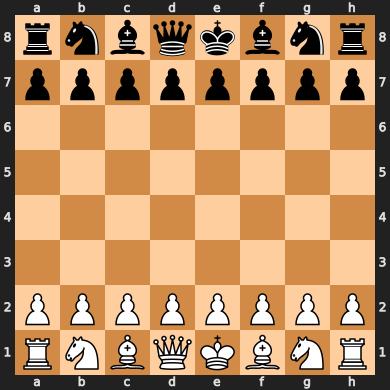

In [8]:
import chess
board = chess.Board()
board

In [10]:
import chess.variant

board = chess.variant.GiveawayBoard()

In [13]:
class PromotingPawnsBoard(chess.Board):
    aliases = ["Promoting Pawns"]
    uci_variant = "promoting_pawns"
    xboard_variant = "promoting_pawns"

    def push(self, move: chess.Move) -> None:
        super().push(move)
        if self.is_capture(move):
            captured_piece = self.piece_at(move.to_square)
            if captured_piece and captured_piece.piece_type == chess.KNIGHT and self.piece_at(move.from_square).piece_type == chess.PAWN:
                self.set_piece_at(move.to_square, chess.Piece(chess.KNIGHT, self.turn))

    def is_variant_end(self) -> bool:
        return self.is_checkmate() or self.is_stalemate() or self.is_insufficient_material()

    def is_variant_win(self) -> bool:
        return self.is_checkmate()

    def is_variant_loss(self) -> bool:
        return self.is_stalemate()

    def is_variant_draw(self) -> bool:
        return self.is_stalemate() or self.is_insufficient_material()

# Example usage
board = PromotingPawnsBoard()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


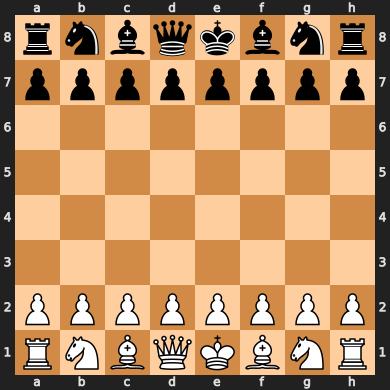

In [14]:
board

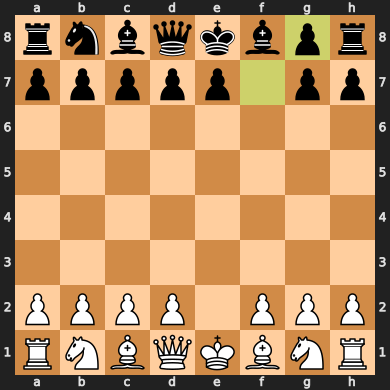

In [19]:
Nf3 = chess.Move.from_uci("f7g8")
>>> board.push(Nf3)
board

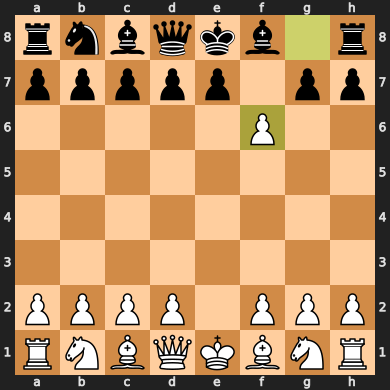

In [20]:
Nf3 = chess.Move.from_uci("g8f6")
>>> board.push(Nf3)
board

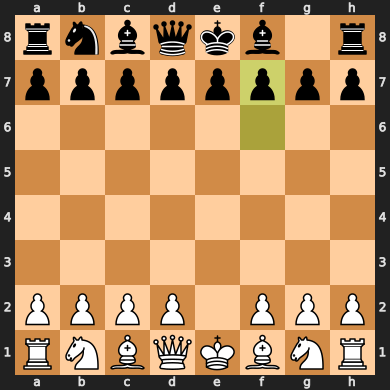

In [21]:
Nf3 = chess.Move.from_uci("f6f7")
>>> board.push(Nf3)
board